In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#data cleaning
data=pd.read_excel("fredgraph_WTI_NatGas_Daily.xls",index_col=0,header=12)
data=data.dropna()

In [3]:
data=data.sort_index()
data

,DHHNGSP,DCOILWTICO
observation_date,,
1997-01-07,3.82,26.25
1997-01-08,3.80,26.55
1997-01-09,3.61,26.30
1997-01-10,3.92,26.15
1997-01-13,4.00,25.20
...,...,...
2022-04-26,6.89,102.62
2022-04-27,6.91,101.96
2022-04-28,6.97,105.47


<AxesSubplot:xlabel='observation_date'>

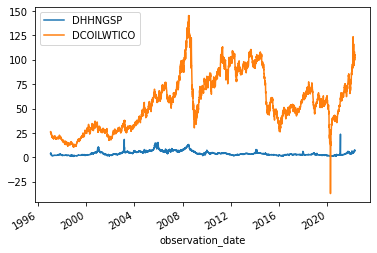

In [4]:
#plot the prices
data.plot()

In [5]:
corr=np.corrcoef(data['DHHNGSP'],data['DCOILWTICO'])
corr

array([[1.        , 0.35821135],
       [0.35821135, 1.        ]])

In [69]:
roa=corr[0][1]
std_1=np.std(data['DHHNGSP'])
std_2=np.std(data['DCOILWTICO'])
hedge_ratio=-std_1/std_2#-roa*
hedge_ratio

-0.07692016754045117

In [70]:
NVec = 2; #Need two prices
NTSteps =len(data)
Weights = np.zeros(NVec)
Weights[0] = 1.0
Weights[1] = hedge_ratio
Weights

array([ 1.        , -0.07692017])

In [71]:
prices = np.zeros((NTSteps,NVec))
for k in range(NTSteps):
    for i in range(NVec):
        prices[k,i]= data.iloc[k,i]* Weights[i]
prices

array([[ 3.82      , -2.0191544 ],
       [ 3.8       , -2.04223045],
       [ 3.61      , -2.02300041],
       ...,
       [ 6.97      , -8.11277007],
       [ 6.84      , -8.04508032],
       [ 7.3       , -8.09046322]])

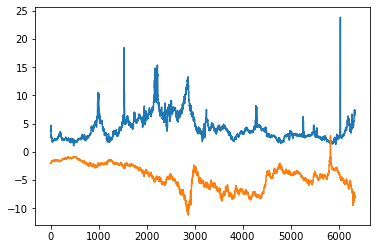

In [72]:
plt.plot(prices)

#### Constructing a Kalman FIlter - Vector of a space NVec

In [73]:
KPrice = np.zeros((NTSteps,NVec));
SMA_Price = np.zeros((NTSteps,NVec));

In [74]:
# A simple Unit Matrix
Unit = np.eye(NVec)

#Initial State
KPrice_Init = np.zeros(NVec)
KCovPrice_Init = np.zeros((NVec, NVec))

# Predicted State
KPrice_Pred = np.zeros(NVec)
KCovPrice_Pred = np.zeros((NVec, NVec))

# Observation and Error
Meas = np.zeros(NVec)
Meas_Error = np.zeros(NVec)

# Corrector State (Posteriori)
KPrice_Corr = np.zeros(NVec)
KCovPrice_Corr = np.zeros((NVec, NVec))

# Intermeditae Matrices
SMat = np.zeros((NVec, NVec))
SMatInv = np.zeros((NVec, NVec))
KalmanGain = np.eye(NVec)


# Initilize State-Dynamics & Observation-Transformation    
FMat = np.eye(NVec)
HMat = np.eye(NVec)
QMat = np.array([(1, 0.25),(0.25, 1)])
RMat = np.array([(2, 0.5),(0.5, 2)])
SMat = RMat
SMatInv = np.linalg.inv(SMat)

In [75]:
for i in range(NVec):
    KPrice[0,i] = prices[0,i];  
    SMA_Price[0,i] = prices[0,i];
    for j in range(NVec):
        KCovPrice_Corr[i, j] = QMat[i,j];

In [76]:
KPrice

array([[ 3.82     , -2.0191544],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       ...,
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ]])

In [77]:
KCovPrice_Corr

array([[1.  , 0.25],
       [0.25, 1.  ]])

In [78]:
#Actual time-stepping 
for k in range(1,NTSteps):
    for i in range(0,NVec):
        Meas[i] = prices[k,i]
        KPrice_Init[i] = KPrice[k-1,i]
        if k == 1:
            for j in range(0,NVec):
                KCovPrice_Init[i,j] = KCovPrice_Corr[i,j]
    KPrice_Pred = np.dot(FMat,KPrice_Init)
    KCovPrice_Pred = np.dot(np.dot(FMat,KCovPrice_Init),FMat.T) + QMat

    Meas_Error = Meas - np.dot(HMat,KPrice_Pred)
    
    SMat = np.dot(np.dot(HMat,KCovPrice_Pred),HMat.T) + RMat
    SMatInv = np.linalg.inv(SMat)

    KalmanGain = np.dot(np.dot(KCovPrice_Pred,HMat.T),SMatInv)
    
    KPrice_Corr = KPrice_Pred + np.dot(KalmanGain,Meas_Error)
    
    KCovPrice_Corr =np.dot((Unit - np.dot(KalmanGain, HMat)),KCovPrice_Pred)
    
    for i in range(NVec): 
        KPrice[k,i] = KPrice_Corr[i]
        for j in range(NVec):
            KCovPrice_Init[i,j] = KCovPrice_Corr[i,j]
     
    # 4-point Simple Moving Average
    for i in range(NVec):
        SMA_Price[k,i] = prices[k,i]
        if k > 3 :
            SMA_Price[k,i] = 0.25 * (prices[k,i] + prices[k-1,i] + prices[k-2,i] + prices[k-3,i])

In [79]:
KPrice

array([[ 3.82      , -2.0191544 ],
       [ 3.81      , -2.03069242],
       [ 3.71      , -2.02684641],
       ...,
       [ 6.90091536, -7.97905289],
       [ 6.87045768, -8.01206661],
       [ 7.08522884, -8.05126491]])

In [80]:
SMA_Price

array([[ 3.82      , -2.0191544 ],
       [ 3.8       , -2.04223045],
       [ 3.61      , -2.02300041],
       ...,
       [ 6.7975    , -7.87758666],
       [ 6.9025    , -7.97354457],
       [ 7.005     , -8.02277347]])

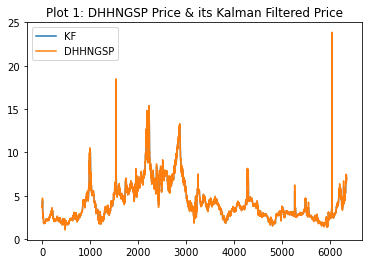

In [81]:
plt.plot(KPrice[:,0],label='KF')
plt.plot(prices[:,0],label='DHHNGSP')
plt.title('Plot 1: DHHNGSP Price & its Kalman Filtered Price')
plt.legend()

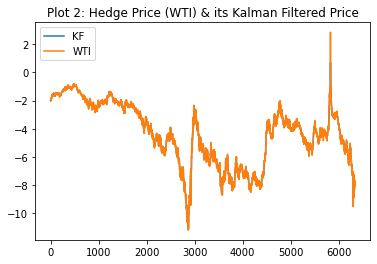

In [82]:
plt.plot(KPrice[:,1],label='KF')
plt.plot(prices[:,1],label='WTI')
plt.title('Plot 2: Hedge Price (WTI) & its Kalman Filtered Price')
plt.legend()

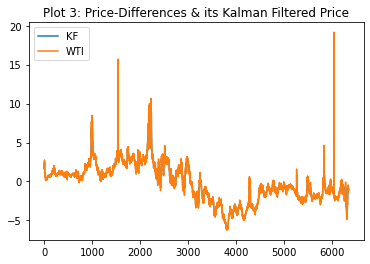

In [83]:
plt.plot(KPrice[:,0]+KPrice[:,1],label='KF')
plt.plot(prices[:,0]+prices[:,1],label='WTI')
plt.title("Plot 3: Price-Differences & its Kalman Filtered Price")
plt.legend()

In [84]:
prices

array([[ 3.82      , -2.0191544 ],
       [ 3.8       , -2.04223045],
       [ 3.61      , -2.02300041],
       ...,
       [ 6.97      , -8.11277007],
       [ 6.84      , -8.04508032],
       [ 7.3       , -8.09046322]])

In [85]:
#Compute the deviation from the Kalman Filter
Price_Minus_KPrice = np.zeros(NTSteps)
ActualPrice = np.zeros(NTSteps)
ActualPriceKalman = np.zeros(NTSteps)
DPriceSpread = np.zeros(NTSteps)
NStocks = np.zeros(NTSteps)
cross = np.zeros(NTSteps)
CashPortValue = np.zeros(NTSteps)
signal = np.zeros(NTSteps)
PortfolioShift = 250;
for k in range(NTSteps):
    ActualPrice[k] = PortfolioShift;
    ActualPriceKalman[k] = PortfolioShift;
    for i in range(NVec):
        ActualPrice[k] = ActualPrice[k] + prices[k,i]
        ActualPriceKalman[k] = ActualPriceKalman[k] + KPrice[k,i]
ActualPrice

array([251.8008456 , 251.75776955, 251.58699959, ..., 248.85722993,
       248.79491968, 249.20953678])

In [86]:
ActualPriceKalman

array([251.8008456 , 251.77930758, 251.68315359, ..., 248.92186247,
       248.85839107, 249.03396393])

In [87]:
# Buy/Sell the Portfolio, not individual positions, making a Static Portfolio assumption
# All prices in terms of Actual Prices
Price_Minus_KPrice[0] = ActualPrice[0] - ActualPriceKalman[0]
DPriceSpread[0] = 0
portValues=np.zeros(NTSteps)
Portfolio_Value = 1000000.00
TradeAmount = 100000.00
portValues[0]= Portfolio_Value
CashPortValue[0] = Portfolio_Value - ActualPrice[1]
NStocks[0]= 1

In [88]:
Price_Minus_KPrice

array([0., 0., 0., ..., 0., 0., 0.])

In [89]:
NStocks

array([1., 0., 0., ..., 0., 0., 0.])

In [90]:
#Actual time-stepping  of the Strategy S():
for k in range(1,NTSteps):
    
    CashPortValue[k] = CashPortValue[k-1]
    NStocks[k] = NStocks[k-1]
    
    Price_Minus_KPrice[k] = ActualPrice[k] - ActualPriceKalman[k]
    DPriceSpread[k] = Price_Minus_KPrice[k] - Price_Minus_KPrice[k-1]
    
    # Cross = 1, Bull-Cross [Bear-Stage to Bull-Stage]
    # Cross = -1, Bear-Cross [Bull-Stage to Bear-Stage]
    # Cross = 0, Within a Cross [Search for a peak to buy or sell]
    
    # Cross Start [Previous End]
  
    if (Price_Minus_KPrice[k] * Price_Minus_KPrice[k-1] <= 0):
        if (Price_Minus_KPrice[k] >= 0):
            cross[k] = -1 # Bear-Cross
        else:
            cross[k] = 1 # Bull-Cross
    #print(NStocks)
    # Within a Cross searching for Peak [to buy or sell]:
    signal[k] = 0
    if (DPriceSpread[k]*DPriceSpread[k-1]< 0)and(cross[k] == 0):
        if (Price_Minus_KPrice[k] > 0):
           
            # Sell Stocks
            if NStocks[k] > 0:
               
                signal[k] = -1
                CashPortValue[k] = CashPortValue[k] + NStocks[k]*ActualPrice[k]
                NStocks[k] = 0
 
        else:
            # Buy Stocks
            if CashPortValue[k] > TradeAmount:
                NStocks[k] = NStocks[k] + (TradeAmount / ActualPrice[k])
                CashPortValue[k] = CashPortValue[k] - TradeAmount
                signal[k] = 1

#Liquidate all Stocks
if NStocks[NTSteps-1] > 0:
    CashPortValue[NTSteps-1] = CashPortValue[NTSteps-1]+ np.dot(NStocks[NTSteps-1],ActualPrice[NTSteps-1-1])
    NStocks[NTSteps-1] = 0


# History of the total Portfolio value
for k in range(NTSteps):
    portValues[k] = CashPortValue[k] + np.dot(NStocks[k],ActualPrice[k])

#Non-Dimenstionalize the portfolio Values [starting from 1].
portValues = portValues / Portfolio_Value

In [91]:
portValues

array([1.00000004, 1.        , 0.99999983, ..., 1.02734575, 1.02734575,
       1.02734575])

In [92]:
KPrice

array([[ 3.82      , -2.0191544 ],
       [ 3.81      , -2.03069242],
       [ 3.71      , -2.02684641],
       ...,
       [ 6.90091536, -7.97905289],
       [ 6.87045768, -8.01206661],
       [ 7.08522884, -8.05126491]])

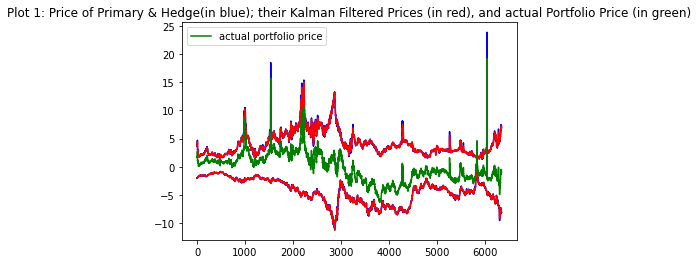

In [93]:
plt.plot(prices,color="blue")
plt.plot(KPrice,color="red")
plt.plot(prices[:,0]+prices[:,1],label='actual portfolio price',color="green")
plt.title('Plot 1: Price of Primary & Hedge(in blue); their Kalman Filtered Prices (in red), and actual Portfolio Price (in green)')
plt.legend()

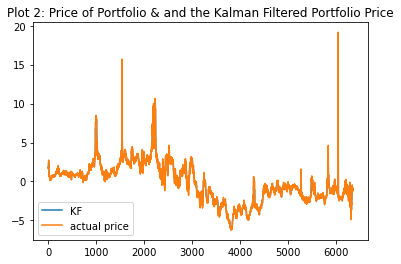

In [94]:
plt.plot(KPrice[:,0]+KPrice[:,1],label='KF')
plt.plot(prices[:,0]+prices[:,1],label='actual price')
plt.title('Plot 2: Price of Portfolio & and the Kalman Filtered Portfolio Price')
plt.legend()

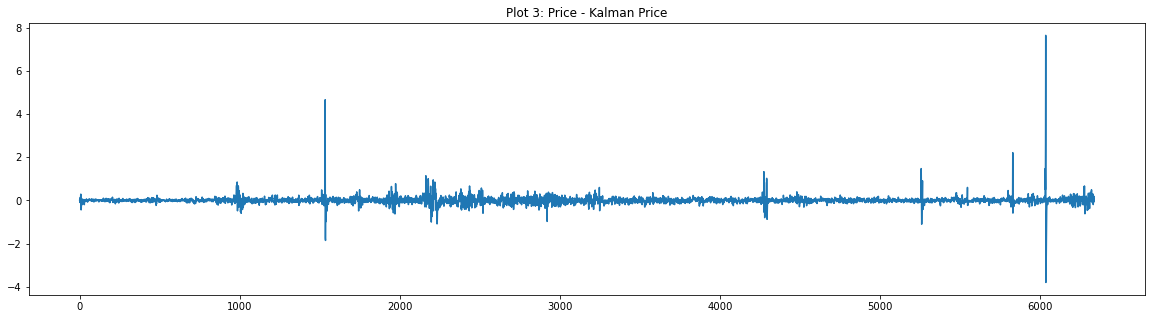

In [95]:
plt.figure(figsize=(20,5))
plt.plot(Price_Minus_KPrice)
plt.title('Plot 3: Price - Kalman Price')
plt.show()

Text(0.5, 1.0, 'Plot 4: Signal')

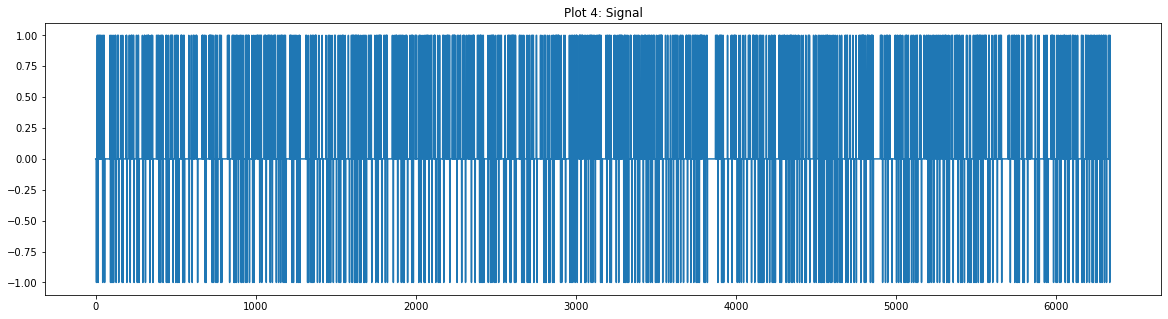

In [96]:
plt.figure(figsize=(20,5))
plt.plot(signal)
plt.title('Plot 4: Signal')

Text(0.5, 1.0, 'Plot 5: Number of Portfolios')

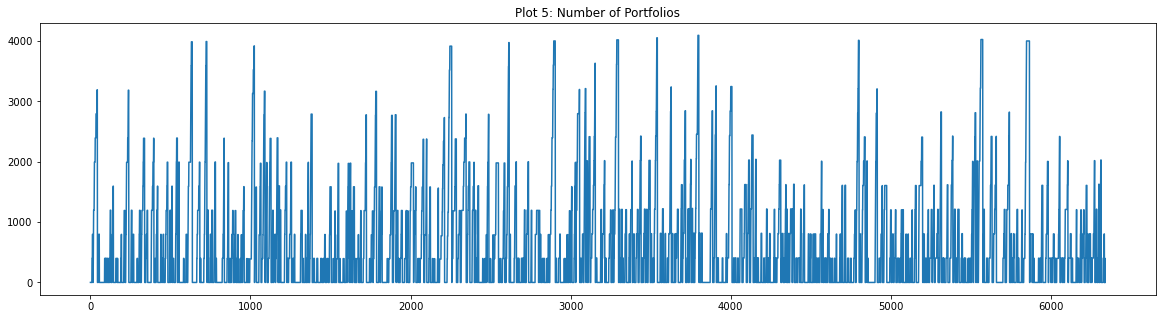

In [97]:
plt.figure(figsize=(20,5))
plt.plot(NStocks)
plt.title('Plot 5: Number of Portfolios')

Text(0.5, 1.0, 'Plot 6: Value in Cash')

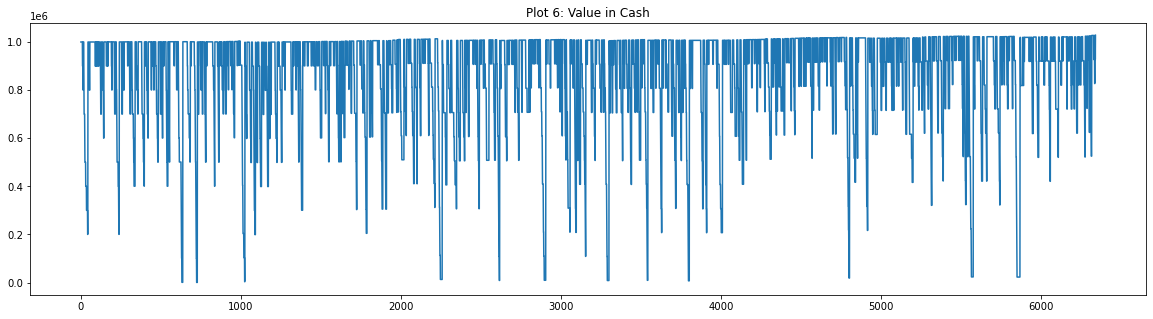

In [98]:
plt.figure(figsize=(20,5))
plt.plot(CashPortValue)
plt.title('Plot 6: Value in Cash')

Text(0.5, 1.0, 'Plot 7: Portfolio Value with time')

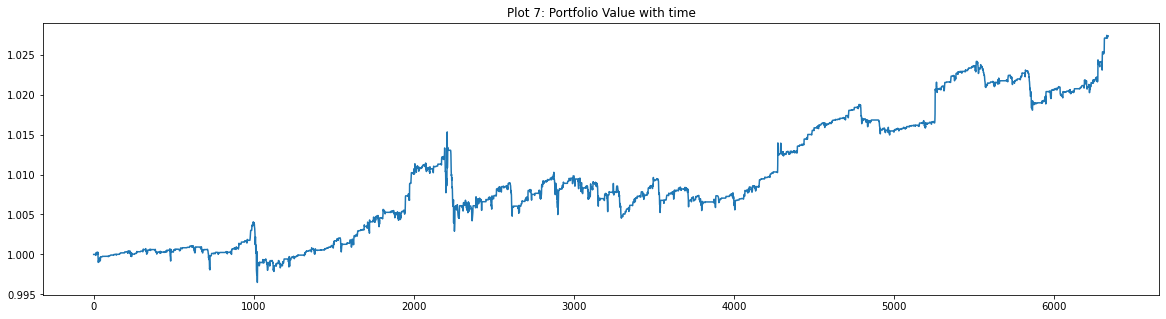

In [99]:
plt.figure(figsize=(20,5))
plt.plot(portValues)
plt.title('Plot 7: Portfolio Value with time')